In [4]:
import torch
import numpy as np

### Zeroth-order gradient estimate:

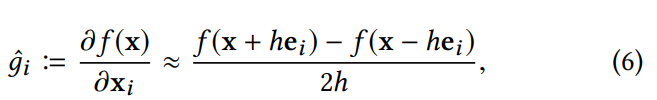

In [ ]:
def zero_order_gradient(f, x, i, h=1e-4):
    e_i = torch.zeros_like(x)
    e_i[i] = 1.0
    return (f(x + h * e_i) - f(x - h * e_i)) / (2 * h)
    

def zero_order_full_gradient(f, x, h=1e-4):
    p = x.size[0]
    grad_hat = torch.zeros_like(x)

    for i in range(p):
        grad_hat[i] = zero_order_gradient(f, x, i, h)

    return grad_hat

### Zeroth order hessian estimate:

could be done with gradient estimate so we only need to evaluate $f(\mathbf{x} + h \mathbf{e}_i)$ and $f(\mathbf{x} - h \mathbf{e}_i)$ once. These steps are expensive because $f$ is a neural network.

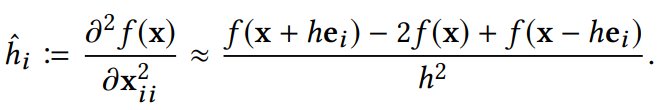

In [ ]:
def zero_order_hessian(f, x, i, h=1e-4):
    e_i = torch.zeros_like(x)
    e_i[i] = 1.0
    return (f(x + h * e_i) - 2*f(x) + f(x - h * e_i)) / (h**2)


# Diagonal entries only as we only need these for Newton
def zero_order_full_hessian(f, x, h=1e-4):
    p = x.size[0]
    hessian_hat = torch.zeros_like(x)
    for i in range(p):
        hessian_hat[i] = zero_order_hessian(f, x, i, h)
    return hessian_hat

### Zeroth-order ADAM

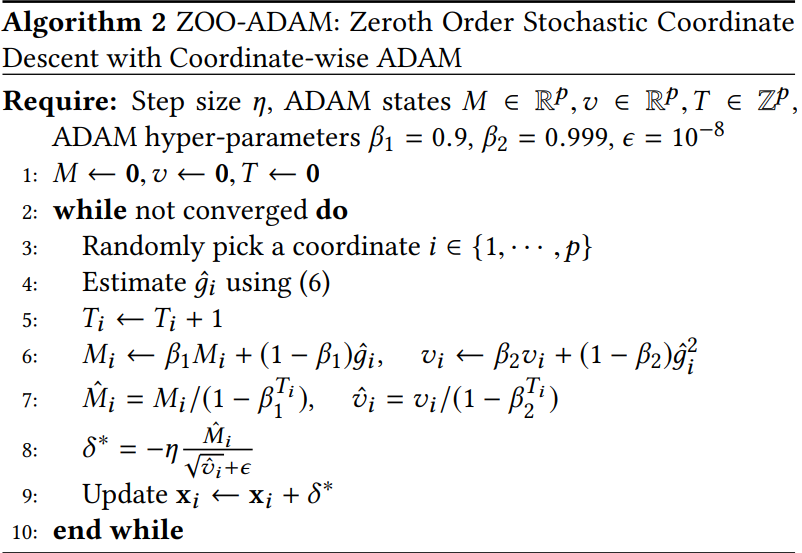

In [ ]:
def zero_order_adam(f, x, i, h, eta, MAX_ITER, beta_1=0.99, beta_2=0.999, eps=1e-8):

    M = torch.zeros_like(x)
    v = torch.zeros_like(x)
    T = torch.zeros_like(x)

    for _ in range(MAX_ITER):

        g_hat_i = zero_order_gradient(f, x, i, h)
        T[i] += 1
        M[i] = beta_1 * M[i] + (1 - beta_1) * g_hat_i
        v[i] = beta_2 * v[i] + (1 - beta_2)* g_hat_i**2
        
        M_i_hat = M[i] / (1 - beta_1**T[i])
        V_i_hat = v[i] / (1 - beta_2**T[i])

        delta_star = - eta * M_i_hat / (torch.sqrt(V_i_hat) + eps)
        x[i] += delta_star
        
    return x

### Coordinate descent with Newton's method


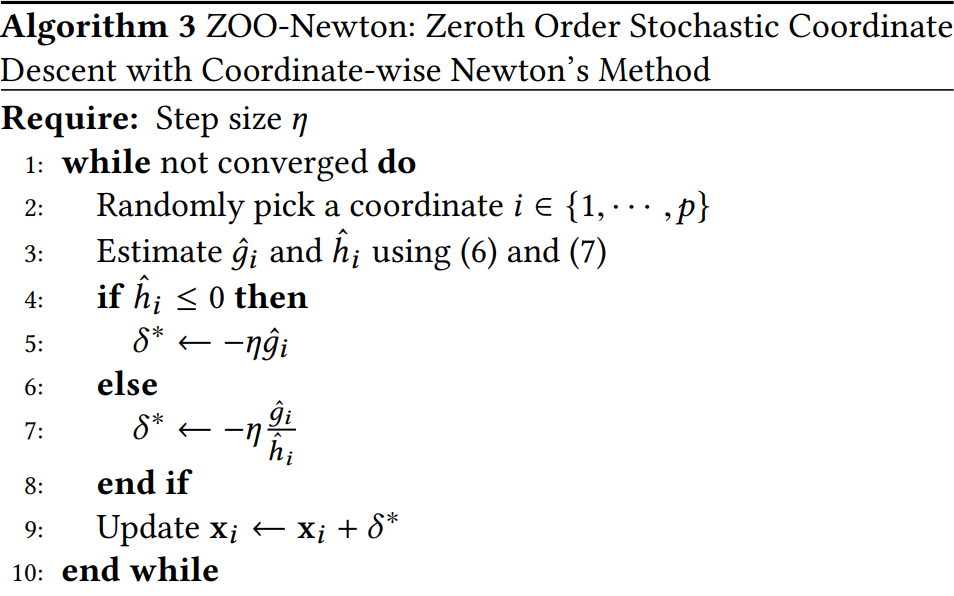

In [ ]:
def coordinate_descent_newton(f, x, h, i, eta, MAX_ITER):
    for _ in range(MAX_ITER):
        g_i = zero_order_gradient(f, x, i, h)
        h_i = zero_order_hessian(f, x, i, h)

        #ignore hessian update if not psd
        delta_star = - eta * g_i if h <= 0 else - eta * (g_i/h_i)

        x[i] += delta_star

### Coordinate descent with either Newton or Adam

We could extend to other zeroth-order methods to compute $\argmin_{\delta \in \mathbb{R}^p}(f(\mathbf{x} + \delta \mathbf{e}_i))$

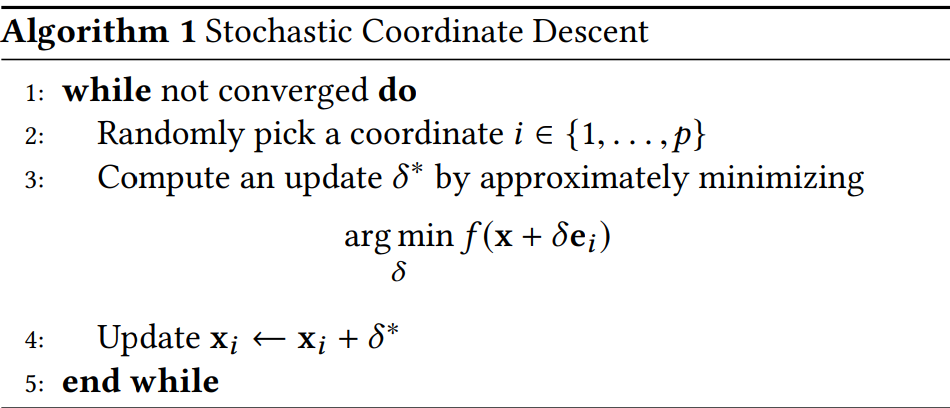

In [ ]:
def coordinate_descent(f, x, h, MAX_ITER_CD, eta, MAX_ITER_METH, mode, beta_1=0.99, beta_2=0.999, eps=1e-8):
    p = x.size[0]
    for _ in range(MAX_ITER_CD):
        i = np.random.randint(p)
        if mode == "adam":
            x = zero_order_adam(f, x, i, h, eta, MAX_ITER_METH, beta_1, beta_2, eps)
        elif mode == "newton":
            x = coordinate_descent_newton(f, x, h, i, MAX_ITER_METH)
        else:
            print(f"{mode} is not a valid method, please provide either adam or newton")
            break

        


    return x